In [271]:
from pathlib import Path
import json
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split

# pipeline utilities
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer

# preprocessing
from sklearn.preprocessing import PowerTransformer, MinMaxScaler
from sklearn.metrics import make_scorer, average_precision_score, roc_auc_score
from sklearn.decomposition import PCA

# validation
from sklearn.model_selection import RepeatedKFold, cross_val_score

# models
from sklearn.dummy import DummyClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC, SVC
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier

In [269]:
# get train and test datasets
# if missing then run 'make inputs'
input_dir = '../data/processed/binary_independent'
X_train = pd.read_pickle(Path(f'{input_dir}/X_train.pkl').resolve())
X_test = pd.read_pickle(Path(f'{input_dir}/X_test.pkl').resolve())
y_train = pd.read_pickle(Path(f'{input_dir}/y_train.pkl').resolve())
y_test = pd.read_pickle(Path(f'{input_dir}/y_test.pkl').resolve())

print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

(8103, 10)
(2026, 10)
(8103,)
(2026,)


In [39]:
# numeric features that need transformation
real_features = ['mintemp', 'maxtemp', 'minlight', 'maxlight', 'minsound', 'maxsound', 'co2', 'co2slope']

# scorer: Area under Precision-Recall curve (PR-AUC)
scorer = make_scorer(score_func=average_precision_score)

# 10x Repeated 5-fold cross-validation
kf = RepeatedKFold(n_splits=5, n_repeats=10, random_state=42)

# dictionary for crossvalidation results {model_name: list_of_scores}
model_results = {}

## Dummy model

In [173]:
model = DummyClassifier()

results = cross_val_score(model, X_train, y_train, cv=kf, scoring=scorer)
median = np.median(results)
lower = max(0.0, np.percentile(results, 2.5))
upper = min(1.0, np.percentile(results, 97.5))
print(f"{model.__class__.__name__}: {median:.4f} ({lower} - {upper})")

model_results[f'{model.__class__.__name__}'] = results

DummyClassifier: 0.1863 (0.16859286105970253 - 0.20158852560148058)


## Logistic Regression models

In [175]:
# without power transformation, without PCA
model = LogisticRegression(random_state=42)

numTransformer = Pipeline(steps=[
    ('scaler', MinMaxScaler()),
])

preprocessor = ColumnTransformer(
    transformers=[
        ('numeric', numTransformer, real_features),
    ]
)

estimator = Pipeline(
    steps=[
        ('preprocessor', preprocessor),
        ('model', model)
    ]
)

results = cross_val_score(estimator, X_train, y_train, cv=kf, scoring=scorer)
median = np.median(results)
lower = max(0.0, np.percentile(results, 2.5))
upper = min(1.0, np.percentile(results, 97.5))
print(f"{model.__class__.__name__}: {median:.4f} ({lower} - {upper})")

model_results[f'{model.__class__.__name__}'] = results

LogisticRegression: 0.9197 (0.8888295290225906 - 0.9500750728417551)


In [176]:
# with power transformation, without PCA
model = LogisticRegression(random_state=42)

numTransformer = Pipeline(steps=[
    ('scaler', MinMaxScaler()),
    ('power_transformer', PowerTransformer())
])

preprocessor = ColumnTransformer(
    transformers=[
        ('numeric', numTransformer, real_features),
    ]
)

estimator = Pipeline(
    steps=[
        ('preprocessor', preprocessor),
        ('model', model)
    ]
)

results = cross_val_score(estimator, X_train, y_train, cv=kf, scoring=scorer)
median = np.median(results)
lower = max(0.0, np.percentile(results, 2.5))
upper = min(1.0, np.percentile(results, 97.5))
print(f"{model.__class__.__name__}: {median:.4f} ({lower} - {upper})")

model_results[f'{model.__class__.__name__} (PT)'] = results

LogisticRegression: 0.9442 (0.9227141103981789 - 0.9636146501560633)


In [177]:
# without power transformation, with PCA
model = LogisticRegression(random_state=42)

numTransformer = Pipeline(steps=[
    ('scaler', MinMaxScaler()),
])

preprocessor = ColumnTransformer(
    transformers=[
        ('numeric', numTransformer, real_features),
    ]
)

estimator = Pipeline(
    steps=[
        ('preprocessor', preprocessor),
        ('dimred', PCA(n_components=7, random_state=42)),
        ('model', model)
    ]
)

results = cross_val_score(estimator, X_train, y_train, cv=kf, scoring=scorer)
median = np.median(results)
lower = max(0.0, np.percentile(results, 2.5))
upper = min(1.0, np.percentile(results, 97.5))
print(f"{model.__class__.__name__}: {median:.4f} ({lower} - {upper})")

model_results[f'{model.__class__.__name__} (PCA)'] = results

LogisticRegression: 0.9197 (0.8888295290225906 - 0.9500750728417551)


In [178]:
# with power transformation, with PCA
model = LogisticRegression(random_state=42)

numTransformer = Pipeline(steps=[
    ('scaler', MinMaxScaler()),
    ('power_transformer', PowerTransformer())
])

preprocessor = ColumnTransformer(
    transformers=[
        ('numeric', numTransformer, real_features),
    ]
)

estimator = Pipeline(
    steps=[
        ('preprocessor', preprocessor),
        ('dimred', PCA(n_components=7, random_state=42)),
        ('model', model)
    ]
)

results = cross_val_score(estimator, X_train, y_train, cv=kf, scoring=scorer)
median = np.median(results)
lower = max(0.0, np.percentile(results, 2.5))
upper = min(1.0, np.percentile(results, 97.5))
print(f"{model.__class__.__name__}: {median:.4f} ({lower} - {upper})")

model_results[f'{model.__class__.__name__} (PT, PCA)'] = results

LogisticRegression: 0.9430 (0.9238184787707092 - 0.9627497096885795)


## Support Vector Machine models

### Linear SVC

In [179]:
# Linear SVC without power transformation, without PCA
model = LinearSVC(random_state=42)

numTransformer = Pipeline(steps=[
    ('scaler', MinMaxScaler()),
])

preprocessor = ColumnTransformer(
    transformers=[
        ('numeric', numTransformer, real_features),
    ]
)

estimator = Pipeline(
    steps=[
        ('preprocessor', preprocessor),
        ('model', model)
    ]
)

results = cross_val_score(estimator, X_train, y_train, cv=kf, scoring=scorer)
median = np.median(results)
lower = max(0.0, np.percentile(results, 2.5))
upper = min(1.0, np.percentile(results, 97.5))
print(f"{model.__class__.__name__}: {median:.4f} ({lower} - {upper})")

model_results[f'{model.__class__.__name__}'] = results

LinearSVC: 0.9447 (0.9232025139200671 - 0.9569733977366971)


In [180]:
# Linear SVC with power transformation, without PCA
model = LinearSVC(random_state=42)

numTransformer = Pipeline(steps=[
    ('scaler', MinMaxScaler()),
    ('power_transformer', PowerTransformer())
])

preprocessor = ColumnTransformer(
    transformers=[
        ('numeric', numTransformer, real_features),
    ]
)

estimator = Pipeline(
    steps=[
        ('preprocessor', preprocessor),
        ('model', model)
    ]
)

results = cross_val_score(estimator, X_train, y_train, cv=kf, scoring=scorer)
median = np.median(results)
lower = max(0.0, np.percentile(results, 2.5))
upper = min(1.0, np.percentile(results, 97.5))
print(f"{model.__class__.__name__}: {median:.4f} ({lower} - {upper})")

model_results[f'{model.__class__.__name__} (PT)'] = results

LinearSVC: 0.9468 (0.9207472229895081 - 0.9610559355340033)


In [181]:
# Linear SVC without power transformation, with PCA
model = LinearSVC(random_state=42)

numTransformer = Pipeline(steps=[
    ('scaler', MinMaxScaler()),
])

preprocessor = ColumnTransformer(
    transformers=[
        ('numeric', numTransformer, real_features),
    ]
)

estimator = Pipeline(
    steps=[
        ('preprocessor', preprocessor),
        ('dimred', PCA(n_components=7, random_state=42)),
        ('model', model)
    ]
)

results = cross_val_score(estimator, X_train, y_train, cv=kf, scoring=scorer)
median = np.median(results)
lower = max(0.0, np.percentile(results, 2.5))
upper = min(1.0, np.percentile(results, 97.5))
print(f"{model.__class__.__name__}: {median:.4f} ({lower} - {upper})")

model_results[f'{model.__class__.__name__} (PCA)'] = results

LinearSVC: 0.9441 (0.9226290437311941 - 0.9580700696861448)


In [259]:
# Linear SVC with power transformation, with PCA
model = LinearSVC(random_state=42)

numTransformer = Pipeline(steps=[
    ('scaler', MinMaxScaler()),
    ('power_transformer', PowerTransformer())
])

preprocessor = ColumnTransformer(
    transformers=[
        ('numeric', numTransformer, real_features),
    ]
)

estimator = Pipeline(
    steps=[
        ('preprocessor', preprocessor),
        ('dimred', PCA(n_components=7, random_state=42)),
        ('model', model)
    ]
)

results = cross_val_score(estimator, X_train, y_train, cv=kf, scoring=scorer)
median = np.median(results)
lower = max(0.0, np.percentile(results, 2.5))
upper = min(1.0, np.percentile(results, 97.5))
print(f"{model.__class__.__name__}: {median:.4f} ({lower} - {upper})")

model_results[f'{model.__class__.__name__} (PT, PCA)'] = results

LinearSVC: 0.9433 (0.9239000329907664 - 0.9626019450271588)


### SVC with RBF kernel

In [183]:
# RBF SVC without power transformation, without PCA
model = SVC(kernel='rbf', random_state=42)

numTransformer = Pipeline(steps=[
    ('scaler', MinMaxScaler()),
])

preprocessor = ColumnTransformer(
    transformers=[
        ('numeric', numTransformer, real_features),
    ]
)

estimator = Pipeline(
    steps=[
        ('preprocessor', preprocessor),
        ('model', model)
    ]
)

results = cross_val_score(estimator, X_train, y_train, cv=kf, scoring=scorer)
median = np.median(results)
lower = max(0.0, np.percentile(results, 2.5))
upper = min(1.0, np.percentile(results, 97.5))
print(f"{model.__class__.__name__}: {median:.4f} ({lower} - {upper})")

model_results[f'{model.__class__.__name__}'] = results

SVC: 0.9887 (0.9756814062452525 - 0.9973465184896111)


In [184]:
# RBF SVC with power transformation, without PCA
model = SVC(kernel='rbf', random_state=42)

numTransformer = Pipeline(steps=[
    ('scaler', MinMaxScaler()),
    ('power_transformer', PowerTransformer())
])

preprocessor = ColumnTransformer(
    transformers=[
        ('numeric', numTransformer, real_features),
    ]
)

estimator = Pipeline(
    steps=[
        ('preprocessor', preprocessor),
        ('model', model)
    ]
)

results = cross_val_score(estimator, X_train, y_train, cv=kf, scoring=scorer)
median = np.median(results)
lower = max(0.0, np.percentile(results, 2.5))
upper = min(1.0, np.percentile(results, 97.5))
print(f"{model.__class__.__name__}: {median:.4f} ({lower} - {upper})")

model_results[f'{model.__class__.__name__} (PT)'] = results

SVC: 0.9869 (0.9703849797931122 - 0.9967295742326936)


In [185]:
# RBF SVC without power transformation, with PCA
model = SVC(kernel='rbf', random_state=42)

numTransformer = Pipeline(steps=[
    ('scaler', MinMaxScaler()),
])

preprocessor = ColumnTransformer(
    transformers=[
        ('numeric', numTransformer, real_features),
    ]
)

estimator = Pipeline(
    steps=[
        ('preprocessor', preprocessor),
        ('dimred', PCA(n_components=7, random_state=42)),
        ('model', model)
    ]
)

results = cross_val_score(estimator, X_train, y_train, cv=kf, scoring=scorer)
median = np.median(results)
lower = max(0.0, np.percentile(results, 2.5))
upper = min(1.0, np.percentile(results, 97.5))
print(f"{model.__class__.__name__}: {median:.4f} ({lower} - {upper})")

model_results[f'{model.__class__.__name__} (PCA)'] = results

SVC: 0.9909 (0.9805183154544379 - 0.9974290773829892)


In [260]:
# RBF SVC with power transformation, with PCA
model = SVC(kernel='rbf', random_state=42)

numTransformer = Pipeline(steps=[
    ('scaler', MinMaxScaler()),
    ('power_transformer', PowerTransformer())
])

preprocessor = ColumnTransformer(
    transformers=[
        ('numeric', numTransformer, real_features),
    ]
)

estimator = Pipeline(
    steps=[
        ('preprocessor', preprocessor),
        ('dimred', PCA(n_components=7, random_state=42)),
        ('model', model)
    ]
)

results = cross_val_score(estimator, X_train, y_train, cv=kf, scoring=scorer)
median = np.median(results)
lower = max(0.0, np.percentile(results, 2.5))
upper = min(1.0, np.percentile(results, 97.5))
print(f"{model.__class__.__name__}: {median:.4f} ({lower} - {upper})")

model_results[f'{model.__class__.__name__} (PT, PCA)'] = results

SVC: 0.9686 (0.9531694696256228 - 0.9810596176231086)


## Bayesian models

In [187]:
# Naive Bayes without power transformation, without PCA
model = GaussianNB()

numTransformer = Pipeline(steps=[
    ('scaler', MinMaxScaler()),
])

preprocessor = ColumnTransformer(
    transformers=[
        ('numeric', numTransformer, real_features),
    ]
)

estimator = Pipeline(
    steps=[
        ('preprocessor', preprocessor),
        ('model', model)
    ]
)

results = cross_val_score(estimator, X_train, y_train, cv=kf, scoring=scorer)
median = np.median(results)
lower = max(0.0, np.percentile(results, 2.5))
upper = min(1.0, np.percentile(results, 97.5))
print(f"{model.__class__.__name__}: {median:.4f} ({lower} - {upper})")

model_results[f'{model.__class__.__name__}'] = results

GaussianNB: 0.8515 (0.825072802714584 - 0.8832107830666)


In [188]:
# Naive Bayes with power transformation, without PCA
model = GaussianNB()

numTransformer = Pipeline(steps=[
    ('scaler', MinMaxScaler()),
    ('power_transformer', PowerTransformer())
])

preprocessor = ColumnTransformer(
    transformers=[
        ('numeric', numTransformer, real_features),
    ]
)

estimator = Pipeline(
    steps=[
        ('preprocessor', preprocessor),
        ('model', model)
    ]
)

results = cross_val_score(estimator, X_train, y_train, cv=kf, scoring=scorer)
median = np.median(results)
lower = max(0.0, np.percentile(results, 2.5))
upper = min(1.0, np.percentile(results, 97.5))
print(f"{model.__class__.__name__}: {median:.4f} ({lower} - {upper})")

model_results[f'{model.__class__.__name__} (PT)'] = results

GaussianNB: 0.8425 (0.8116347948644592 - 0.8684961164549563)


In [189]:
# Naive Bayes without power transformation, with PCA
model = GaussianNB()

numTransformer = Pipeline(steps=[
    ('scaler', MinMaxScaler()),
])

preprocessor = ColumnTransformer(
    transformers=[
        ('numeric', numTransformer, real_features),
    ]
)

estimator = Pipeline(
    steps=[
        ('preprocessor', preprocessor),
        ('dimred', PCA(n_components=7, random_state=42)),
        ('model', model)
    ]
)

results = cross_val_score(estimator, X_train, y_train, cv=kf, scoring=scorer)
median = np.median(results)
lower = max(0.0, np.percentile(results, 2.5))
upper = min(1.0, np.percentile(results, 97.5))
print(f"{model.__class__.__name__}: {median:.4f} ({lower} - {upper})")

model_results[f'{model.__class__.__name__} (PCA)'] = results

GaussianNB: 0.7653 (0.7218801153355275 - 0.7971043850539543)


In [190]:
# Naive Bayes with power transformation, with PCA
model = GaussianNB()

numTransformer = Pipeline(steps=[
    ('scaler', MinMaxScaler()),
    ('power_transformer', PowerTransformer())
])

preprocessor = ColumnTransformer(
    transformers=[
        ('numeric', numTransformer, real_features),
    ]
)

estimator = Pipeline(
    steps=[
        ('preprocessor', preprocessor),
        ('dimred', PCA(n_components=7, random_state=42)),
        ('model', model)
    ]
)

results = cross_val_score(estimator, X_train, y_train, cv=kf, scoring=scorer)
median = np.median(results)
lower = max(0.0, np.percentile(results, 2.5))
upper = min(1.0, np.percentile(results, 97.5))
print(f"{model.__class__.__name__}: {median:.4f} ({lower} - {upper})")

model_results[f'{model.__class__.__name__} (PT, PCA)'] = results

GaussianNB: 0.9074 (0.8856148390836744 - 0.9249239558748599)


## Nearest Neighbors models

In [191]:
# k-Nearest Neighbors without power transformation, without PCA
model = KNeighborsClassifier()

numTransformer = Pipeline(steps=[
    ('scaler', MinMaxScaler()),
])

preprocessor = ColumnTransformer(
    transformers=[
        ('numeric', numTransformer, real_features),
    ]
)

estimator = Pipeline(
    steps=[
        ('preprocessor', preprocessor),
        ('model', model)
    ]
)

results = cross_val_score(estimator, X_train, y_train, cv=kf, scoring=scorer)
median = np.median(results)
lower = max(0.0, np.percentile(results, 2.5))
upper = min(1.0, np.percentile(results, 97.5))
print(f"{model.__class__.__name__}: {median:.4f} ({lower} - {upper})")

model_results[f'{model.__class__.__name__}'] = results

KNeighborsClassifier: 0.9943 (0.9878534507289135 - 1.0)


In [192]:
# k-Nearest Neighbors with power transformation, without PCA
model = KNeighborsClassifier()

numTransformer = Pipeline(steps=[
    ('scaler', MinMaxScaler()),
    ('power_transformer', PowerTransformer())
])

preprocessor = ColumnTransformer(
    transformers=[
        ('numeric', numTransformer, real_features),
    ]
)

estimator = Pipeline(
    steps=[
        ('preprocessor', preprocessor),
        ('model', model)
    ]
)

results = cross_val_score(estimator, X_train, y_train, cv=kf, scoring=scorer)
median = np.median(results)
lower = max(0.0, np.percentile(results, 2.5))
upper = min(1.0, np.percentile(results, 97.5))
print(f"{model.__class__.__name__}: {median:.4f} ({lower} - {upper})")

model_results[f'{model.__class__.__name__} (PT)'] = results

KNeighborsClassifier: 0.9766 (0.9620279502003778 - 0.9916640106120216)


In [193]:
# k-Nearest Neighbors without power transformation, with PCA
model = KNeighborsClassifier()

numTransformer = Pipeline(steps=[
    ('scaler', MinMaxScaler()),
])

preprocessor = ColumnTransformer(
    transformers=[
        ('numeric', numTransformer, real_features),
    ]
)

estimator = Pipeline(
    steps=[
        ('preprocessor', preprocessor),
        ('dimred', PCA(n_components=7, random_state=42)),
        ('model', model)
    ]
)

results = cross_val_score(estimator, X_train, y_train, cv=kf, scoring=scorer)
median = np.median(results)
lower = max(0.0, np.percentile(results, 2.5))
upper = min(1.0, np.percentile(results, 97.5))
print(f"{model.__class__.__name__}: {median:.4f} ({lower} - {upper})")

model_results[f'{model.__class__.__name__} (PCA)'] = results

KNeighborsClassifier: 0.9943 (0.9878534507289135 - 1.0)


In [194]:
# k-Nearest Neighbors with power transformation, with PCA
model = KNeighborsClassifier()

numTransformer = Pipeline(steps=[
    ('scaler', MinMaxScaler()),
    ('power_transformer', PowerTransformer())
])

preprocessor = ColumnTransformer(
    transformers=[
        ('numeric', numTransformer, real_features),
    ]
)

estimator = Pipeline(
    steps=[
        ('preprocessor', preprocessor),
        ('dimred', PCA(n_components=7, random_state=42)),
        ('model', model)
    ]
)

results = cross_val_score(estimator, X_train, y_train, cv=kf, scoring=scorer)
median = np.median(results)
lower = max(0.0, np.percentile(results, 2.5))
upper = min(1.0, np.percentile(results, 97.5))
print(f"{model.__class__.__name__}: {median:.4f} ({lower} - {upper})")

model_results[f'{model.__class__.__name__} (PT, PCA)'] = results

KNeighborsClassifier: 0.9756 (0.95870165725006 - 0.9907480976373546)


## Decision Tree models

In [195]:
# Decision Tree without power transformation, without PCA
model = DecisionTreeClassifier()

numTransformer = Pipeline(steps=[
    ('scaler', MinMaxScaler()),
])

preprocessor = ColumnTransformer(
    transformers=[
        ('numeric', numTransformer, real_features),
    ]
)

estimator = Pipeline(
    steps=[
        ('preprocessor', preprocessor),
        ('model', model)
    ]
)

results = cross_val_score(estimator, X_train, y_train, cv=kf, scoring=scorer)
median = np.median(results)
lower = max(0.0, np.percentile(results, 2.5))
upper = min(1.0, np.percentile(results, 97.5))
print(f"{model.__class__.__name__}: {median:.4f} ({lower} - {upper})")

model_results[f'{model.__class__.__name__}'] = results

DecisionTreeClassifier: 0.9908 (0.9833666331576365 - 1.0)


## Ensemble models

In [196]:
# Random Forest without power transformation, without PCA
model = RandomForestClassifier(random_state=42)

numTransformer = Pipeline(steps=[
    ('scaler', MinMaxScaler()),
])

preprocessor = ColumnTransformer(
    transformers=[
        ('numeric', numTransformer, real_features),
    ]
)

estimator = Pipeline(
    steps=[
        ('preprocessor', preprocessor),
        ('model', model)
    ]
)

results = cross_val_score(estimator, X_train, y_train, cv=kf, scoring=scorer)
median = np.median(results)
lower = max(0.0, np.percentile(results, 2.5))
upper = min(1.0, np.percentile(results, 97.5))
print(f"{model.__class__.__name__}: {median:.4f} ({lower} - {upper})")

model_results[f'{model.__class__.__name__}'] = results

RandomForestClassifier: 1.0000 (0.9950440980485192 - 1.0)


In [197]:
# Adaptive Boosting without power transformation, without PCA
model = AdaBoostClassifier(n_estimators=100, random_state=42)

numTransformer = Pipeline(steps=[
    ('scaler', MinMaxScaler()),
])

preprocessor = ColumnTransformer(
    transformers=[
        ('numeric', numTransformer, real_features),
    ]
)

estimator = Pipeline(
    steps=[
        ('preprocessor', preprocessor),
        ('model', model)
    ]
)

results = cross_val_score(estimator, X_train, y_train, cv=kf, scoring=scorer)
median = np.median(results)
lower = max(0.0, np.percentile(results, 2.5))
upper = min(1.0, np.percentile(results, 97.5))
print(f"{model.__class__.__name__}: {median:.4f} ({lower} - {upper})")

model_results[f'{model.__class__.__name__}'] = results

AdaBoostClassifier: 0.9988 (0.9939205604732755 - 1.0)


In [198]:
# Gradient Boosting without power transformation, without PCA
model = GradientBoostingClassifier(n_estimators=200, random_state=42)

numTransformer = Pipeline(steps=[
    ('scaler', MinMaxScaler()),
])

preprocessor = ColumnTransformer(
    transformers=[
        ('numeric', numTransformer, real_features),
    ]
)

estimator = Pipeline(
    steps=[
        ('preprocessor', preprocessor),
        ('model', model)
    ]
)

results = cross_val_score(estimator, X_train, y_train, cv=kf, scoring=scorer)
median = np.median(results)
lower = max(0.0, np.percentile(results, 2.5))
upper = min(1.0, np.percentile(results, 97.5))
print(f"{model.__class__.__name__}: {median:.4f} ({lower} - {upper})")

model_results[f'{model.__class__.__name__}'] = results

GradientBoostingClassifier: 0.9973 (0.9934252008644588 - 1.0)


## Unsupervised approaches

In [63]:
# Train observations must not contain outliers!
X_train_out = X_train[y_train==0]
print(X_train_out.shape)

(6582, 10)


In [156]:
""" Local Outlier Factor """
from sklearn.neighbors import LocalOutlierFactor
 
model = LocalOutlierFactor(n_neighbors=10, contamination=0.2, novelty=True).fit(X_train_out.values)
preds = model.predict(X_test)
# validate against ground truth
average_precision_score(y_test, model.score_samples(X_test))

0.10897820472604394

In [113]:
model = LocalOutlierFactor(novelty=True).fit(X_train_out[['maxsound', 'maxpir']].values)
preds = model.predict(X_test[['maxsound', 'maxpir']])
# validate against ground truth
average_precision_score(y_test, model.score_samples(X_test[['maxsound', 'maxpir']]))

0.10608229716071035

In [99]:
"""One-class Support Vector Machine """
from sklearn.svm import OneClassSVM
model = OneClassSVM(gamma='scale').fit(X_train_out)
# simulate contamination
y_scores = model.score_samples(X_test)
threshold = np.quantile(y_scores, 0.2)
preds = y_scores >= threshold
# validate against ground truth
average_precision_score(y_test, model.score_samples(X_test))

0.1064244923995067

In [109]:
""" Isolation Forest """
from sklearn.ensemble import IsolationForest
model = IsolationForest(random_state=42).fit(X_train_out.values)
preds = model.predict(X_test.values)
# validate against ground truth
average_precision_score(y_test, model.score_samples(X_test.values))

0.10059732736165668

# Performance summary

In [278]:
model_results_out = {k: v.tolist() for k, v in model_results.items()}
model_results_out
with open('model_results.json', 'w') as f:
    json.dump(model_results_out, f)

In [263]:
model_results_df = pd.DataFrame(model_results)
model_results_df

,DummyClassifier,LogisticRegression,LogisticRegression (PT),LogisticRegression (PCA),"LogisticRegression (PT, PCA)",LinearSVC,LinearSVC (PT),LinearSVC (PCA),"LinearSVC (PT, PCA)",SVC,...,"GaussianNB (PT, PCA)",KNeighborsClassifier,KNeighborsClassifier (PT),KNeighborsClassifier (PCA),"KNeighborsClassifier (PT, PCA)",DecisionTreeClassifier,RandomForestClassifier,AdaBoostClassifier,GradientBoostingClassifier,"SVC (PT, PCA)"
0,0.185688,0.915092,0.955644,0.915092,0.955644,0.934488,0.952940,0.929080,0.955644,0.985284,...,0.907507,0.993399,0.980956,0.993399,0.980956,0.991884,1.000000,0.997295,0.994589,0.975547
1,0.186305,0.912278,0.953113,0.912278,0.953113,0.939650,0.955805,0.939650,0.953113,0.994611,...,0.919350,0.997306,0.983228,0.997306,0.980534,1.000000,1.000000,1.000000,1.000000,0.966576
2,0.184454,0.929020,0.935359,0.929020,0.935359,0.948106,0.947141,0.953560,0.938514,0.988484,...,0.924202,0.997272,0.973703,0.997272,0.973703,0.988484,0.994545,1.000000,0.994545,0.964466
3,0.189506,0.914862,0.937234,0.914862,0.934178,0.941748,0.939871,0.941748,0.937234,0.981520,...,0.890252,0.996753,0.975553,0.996753,0.975069,0.994113,1.000000,1.000000,0.996753,0.967637
4,0.192593,0.934174,0.941922,0.934174,0.939339,0.952629,0.944504,0.952629,0.941922,0.991043,...,0.899818,0.990476,0.960776,0.990476,0.958192,0.994217,1.000000,0.997412,1.000000,0.952629
5,0.179519,0.887948,0.935428,0.887948,0.932613,0.924544,0.935428,0.924544,0.929799,0.982478,...,0.901303,0.993756,0.980803,0.993756,0.977471,0.994361,1.000000,1.000000,1.000000,0.970875
6,0.200494,0.919911,0.948936,0.919911,0.956310,0.952365,0.948477,0.952365,0.958769,0.995080,...,0.909226,0.991424,0.976955,0.991424,0.976955,0.991424,1.000000,1.000000,0.996933,0.972552
7,0.188155,0.935479,0.954102,0.935479,0.956763,0.952459,0.948303,0.949798,0.953623,0.997338,...,0.920156,0.997338,0.982839,0.997338,0.985500,0.996732,0.997338,0.996732,0.996732,0.976410
8,0.185185,0.934242,0.936034,0.934242,0.938748,0.951025,0.939199,0.951025,0.936034,0.977082,...,0.907772,0.993377,0.979236,0.996678,0.979236,0.987946,0.997284,0.994568,0.997284,0.977677
9,0.185185,0.918919,0.936785,0.918919,0.931365,0.946456,0.939495,0.941029,0.934075,0.987946,...,0.898581,0.993377,0.975461,0.993377,0.960457,0.985230,1.000000,1.000000,1.000000,0.955030


In [264]:
model_results_df = pd.DataFrame(model_results)
model_results_df = model_results_df.melt(var_name='Classifier', value_name='PR-AUC')

model_results_df['Variant'] = 'Basic'

mask = model_results_df['Classifier'].str.contains('(PT, PCA)', regex=False)
model_results_df.loc[mask, 'Variant'] = 'PT, PCA'
model_results_df['Classifier'] = model_results_df['Classifier'].str.replace(' (PT, PCA)', repl='', regex=False)

mask = model_results_df['Classifier'].str.contains('(PT)', regex=False)
model_results_df.loc[mask, 'Variant'] = 'PT'
model_results_df['Classifier'] = model_results_df['Classifier'].str.replace(' (PT)', repl='', regex=False)

mask = model_results_df['Classifier'].str.contains('(PCA)', regex=False)
model_results_df.loc[mask, 'Variant'] = 'PCA'
model_results_df['Classifier'] = model_results_df['Classifier'].str.replace(' (PCA)', repl='', regex=False)

model_results_df

,Classifier,PR-AUC,Variant
0,DummyClassifier,0.185688,Basic
1,DummyClassifier,0.186305,Basic
2,DummyClassifier,0.184454,Basic
3,DummyClassifier,0.189506,Basic
4,DummyClassifier,0.192593,Basic
...,...,...,...
1245,SVC,0.964637,"PT, PCA"
1246,SVC,0.973064,"PT, PCA"
1247,SVC,0.958363,"PT, PCA"
1248,SVC,0.968598,"PT, PCA"


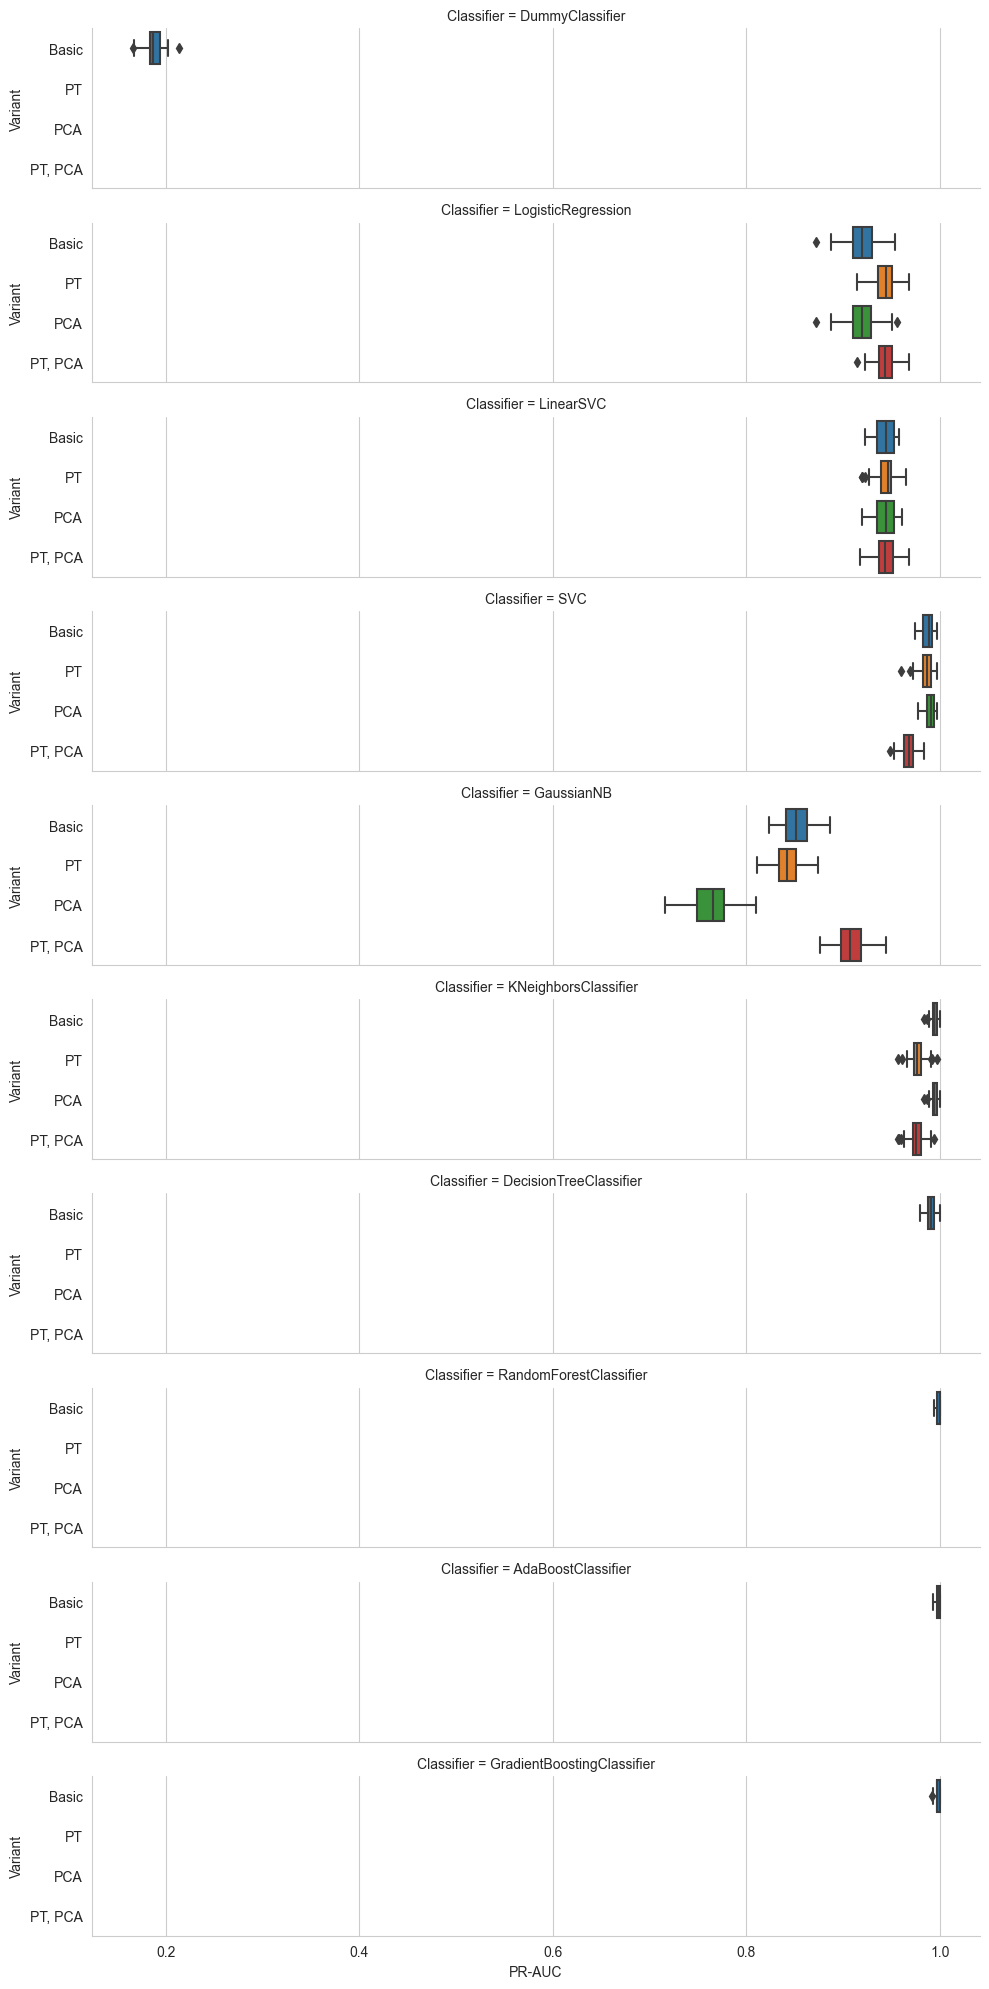

In [267]:
import matplotlib.pyplot as plt
import seaborn as sns

sns.set_style('whitegrid')

sns.catplot(
    data=model_results_df, 
    kind="box",
    x='PR-AUC',
    y='Variant',
    row='Classifier',
    height=2,
    aspect=5,
    orient='h'
)